# Model Workflow & Evaluation

This notebook documents the complete workflow and evaluation process for the credit default prediction model. The process is organized into 8 parts

1. **Data Preparation**: Preparing and aggregating raw data into a usable format for modeling.
2. **Feature Engineering**: Constructing predictive features, handling categorical data and missing values.
3. **Model Training**: Training LightGBM models using stratified cross-validation with full and top features.
4. **Model Evaluation**: Assessing model performance using various classification metrics and visualizations.
5. **Model Explanation**: Interpreting the model with SHAP to identify key global and local predictors.
6. **Business Impact Evaluation**: Comparing model decisions to a baseline and analyzing profit/loss scenarios under different approval thresholds.
7. **Post-deployment Monitoring**: Proposing methods to track model stability and performance over time.
8. **Future Work & Improvement Ideas**: Ideas for improving which could not be explored due to time constraints.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.display.max_columns = None
pd.set_option('display.float_format', '{:.4f}'.format)

In [3]:
data_path = 'home-credit-default-risk/'

## Part 1: Data Preparation

This section outlines the process of transforming raw data into meaningful features for model training. Final feature aggregation is performed at the `SK_ID_CURR` level, with intermediate aggregations at the `SK_ID_BUREAU` level for bureau-related data and at the `SK_ID_PREV` level for previous-application-related data. Selected features are aligned with those identified as important (see Appendix 2).

In [4]:
def describe_df(df):
    print(df.shape)
    
    desc = df.describe()
    display(desc)
    
    if desc.shape[1] == df.shape[1]:
        return
    
    desc_o = df.describe(include='object')
    display(desc_o)

    for c in desc_o.columns:
        if df[c].nunique() < 20:
            print(df[c].fillna('-- null --').value_counts(normalize=True))
            print()
            
def clean_columns_name(df, prefix=''):
    return [(prefix+'_'.join(col)).upper().replace(' ', '_') for col in df.columns]

In [5]:
df_app_train = pd.read_csv(data_path + 'application_train.csv')
df_app_test = pd.read_csv(data_path + 'application_test.csv')

In [6]:
describe_df(df_app_train)

(307511, 122)


,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,307499.0000,307233.0000,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,104582.0000,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,307509.0000,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,134133.0000,306851.0000,246546.0000,151450.0000,127568.0000,157504.0000,103023.0000,92646.0000,143620.0000,152683.0000,154491.0000,98869.0000,124921.0000,97312.0000,153161.0000,93997.0000,137829.0000,151450.0000,127568.0000,157504.0000,103023.0000,92646.0000,143620.0000,152683.0000,154491.0000,98869.0000,124921.0000,97312.0000,153161.0000,93997.0000,137829.0000,151450.0000,127568.0000,157504.0000,103023.0000,92646.0000,143620.0000,152683.0000,154491.0000,98869.0000,124921.0000,97312.0000,153161.0000,93997.0000,137829.0000,159080.0000,306490.0000,306490.0000,306490.0000,306490.0000,307510.0000,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,265992.0000,265992.0000,265992.0000,265992.0000,265992.0000,265992.0000
mean,278180.5186,0.0807,0.4171,168797.9193,599025.9997,27108.5739,538396.2074,0.0209,-16036.9951,63815.0459,-4986.1203,-2994.2024,12.0611,1.0000,0.8199,0.1994,0.9981,0.2811,0.0567,2.1527,2.0525,2.0315,12.0634,0.0151,0.0508,0.0407,0.0782,0.2305,0.1796,0.5021,0.5144,0.5109,0.1174,0.0884,0.9777,0.7525,0.0446,0.0789,0.1497,0.2263,0.2319,0.0663,0.1008,0.1074,0.0088,0.0284,0.1142,0.0875,0.9771,0.7596,0.0426,0.0745,0.1452,0.2223,0.2281,0.0650,0.1056,0.1060,0.0081,0.0270,0.1178,0.0880,0.9778,0.7557,0.0446,0.0781,0.1492,0.2259,0.2316,0.0672,0.1020,0.1086,0.0087,0.0282,0.1025,1.4222,0.1434,1.4053,0.1000,-962.8588,0.0000,0.7100,0.0001,0.0151,0.0881,0.0002,0.0814,0.0039,0.0000,0.0039,0.0000,0.0035,0.0029,0.0012,0.0099,0.0003,0.0081,0.0006,0.0005,0.0003,0.0064,0.0070,0.0344,0.2674,0.2655,1.9000
std,102790.1753,0.2724,

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
count,307511,307511,307511,307511,306219,307511,307511,307511,307511,211120,307511,307511,97216,153214,151170,161756
unique,2,3,2,2,7,8,5,6,6,18,7,58,4,3,7,2
top,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Laborers,TUESDAY,Business Entity Type 3,reg oper account,block of flats,Panel,No
freq,278232,202448,202924,213312,248526,158774,218391,196432,272868,55186,53901,67992,73830,150503,66040,159428


NAME_CONTRACT_TYPE
Cash loans        0.9048
Revolving loans   0.0952
Name: proportion, dtype: float64

CODE_GENDER
F     0.6583
M     0.3416
XNA   0.0000
Name: proportion, dtype: float64

FLAG_OWN_CAR
N   0.6599
Y   0.3401
Name: proportion, dtype: float64

FLAG_OWN_REALTY
Y   0.6937
N   0.3063
Name: proportion, dtype: float64

NAME_TYPE_SUITE
Unaccompanied     0.8082
Family            0.1306
Spouse, partner   0.0370
Children          0.0106
Other_B           0.0058
-- null --        0.0042
Other_A           0.0028
Group of people   0.0009
Name: proportion, dtype: float64

NAME_INCOME_TYPE
Working                0.5163
Commercial associate   0.2329
Pensioner              0.1800
State servant          0.0706
Unemployed             0.0001
Student                0.0001
Businessman            0.0000
Maternity leave        0.0000
Name: proportion, dtype: float64

NAME_EDUCATION_TYPE
Secondary / secondary special   0.7102
Higher education                0.2434
Incomplete higher               

### 1.1) Bureau Data


In [7]:
df_bureau = pd.read_csv(data_path + 'bureau.csv')
df_bureau_bal = pd.read_csv(data_path + 'bureau_balance.csv')

In [8]:
describe_df(df_bureau)

(1716428, 17)


,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
count,1716428.0000,1716428.0000,1716428.0000,1716428.0000,1610875.0000,1082775.0000,591940.0000,1716428.0000,1716415.0000,1458759.0000,1124648.0000,1716428.0000,1716428.0000,489637.0000
mean,278214.9336,5924434.4890,-1142.1077,0.8182,510.5174,-1017.4371,3825.4177,0.0064,354994.5919,137085.1200,6229.5150,37.9128,-593.7483,15712.7577
std,102938.5581,532265.7286,795.1649,36.5444,4994.2198,714.0106,206031.6062,0.0962,1149811.3440,677401.1310,45032.0315,5937.6500,720.7473,325826.9491
min,100001.0000,5000000.0000,-2922.0000,0.0000,-42060.0000,-42023.0000,0.0000,0.0000,0.0000,-4705600.3200,-586406.1150,0.0000,-41947.0000,0.0000
25%,188866.7500,5463953.7500,-1666.0000,0.0000,-1138.0000,-1489.0000,0.0000,0.0000,51300.0000,0.0000,0.0000,0.0000,-908.0000,0.0000
50%,278055.0000,5926303.5000,-987.0000,0.0000,-330.0000,-897.0000,0.0000,0.0000,125518.5000,0.0000,0.0000,0.0000,-395.0000,0.0000
75%,367426.0000,6385681.2500,-474.0000,0.0000,474.0000,-425.0000,0.0000,0.0000,315000.0000,40153.5000,0.0000,0.0000,-33.0000,13500.0000
max,456255.0000,6843457.0000,0.0000,2792.0000,31199.0000,0.0000,115987185.0000,9.0000,585000000.0000,170100000.0000,4705600.3200,3756681.0000,372.0000,118453423.5000


,CREDIT_ACTIVE,CREDIT_CURRENCY,CREDIT_TYPE
count,1716428,1716428,1716428
unique,4,4,15
top,Closed,currency 1,Consumer credit
freq,1079273,1715020,1251615


CREDIT_ACTIVE
Closed     0.6288
Active     0.3674
Sold       0.0038
Bad debt   0.0000
Name: proportion, dtype: float64

CREDIT_CURRENCY
currency 1   0.9992
currency 2   0.0007
currency 3   0.0001
currency 4   0.0000
Name: proportion, dtype: float64

CREDIT_TYPE
Consumer credit                                0.7292
Credit card                                    0.2343
Car loan                                       0.0161
Mortgage                                       0.0107
Microloan                                      0.0072
Loan for business development                  0.0012
Another type of loan                           0.0006
Unknown type of loan                           0.0003
Loan for working capital replenishment         0.0003
Cash loan (non-earmarked)                      0.0000
Real estate loan                               0.0000
Loan for the purchase of equipment             0.0000
Loan for purchase of shares (margin lending)   0.0000
Mobile operator loan                

In [9]:
describe_df(df_bureau_bal)

(27299925, 3)


,SK_ID_BUREAU,MONTHS_BALANCE
count,27299925.0000,27299925.0000
mean,6036297.3330,-30.7417
std,492348.8569,23.8645
min,5001709.0000,-96.0000
25%,5730933.0000,-46.0000
50%,6070821.0000,-25.0000
75%,6431951.0000,-11.0000
max,6842888.0000,0.0000


,STATUS
count,27299925
unique,8
top,C
freq,13646993


STATUS
C   0.4999
0   0.2747
X   0.2128
1   0.0089
5   0.0023
2   0.0009
3   0.0003
4   0.0002
Name: proportion, dtype: float64



1.1.1) `df_bb_status`: Aggregated `bureau_balance` at the `SK_ID_BUREAU` level
- Counting `MONTHS_BALANCE` by each `STATUS`
- Calculating the total number of months

In [10]:
df_bb_status = (
    df_bureau_bal
    .pivot_table(
        index='SK_ID_BUREAU',
        columns='STATUS',
        values='MONTHS_BALANCE',
        aggfunc='count',
        fill_value=0
    )
    .add_prefix('MONTHS_STATUS_')
)
df_bb_status['MONTHS'] = df_bb_status.sum(axis=1)
print(df_bureau_bal.shape, '-->', df_bb_status.shape)

(27299925, 3) --> (817395, 9)


1.1.2) `df_bureau_active`: Aggregated `bureau` and `df_bb_status` at the `SK_ID_CURR` level by loan status (active vs closed)
- Counted number of `SK_ID_BUREAU`
- Aggregated selected amount-related columns (referenced in Appendix 2)
- Merged with df_bb_status and aggregated to the `SK_ID_CURR` level

In [11]:
selected_amt_cols = ['AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_MAX_OVERDUE']
list_credit_active_main = ['Active', 'Closed']

df_bureau.loc[
    df_bureau['CREDIT_ACTIVE'].isin(list_credit_active_main), 'CREDIT_ACTIVE_MAIN'] = df_bureau['CREDIT_ACTIVE']
df_bureau_active = (
    df_bureau
    .merge(df_bb_status, on='SK_ID_BUREAU', how='left')
    .pivot_table(
        index='SK_ID_CURR',
        columns='CREDIT_ACTIVE_MAIN',
        aggfunc={
            'SK_ID_BUREAU': 'count',
            **{c: ['sum', 'max', 'mean'] for c in selected_amt_cols},
            **{c: 'sum' for c in df_bb_status.columns},
        },
        fill_value=0
    )
)
df_bureau_active.columns = clean_columns_name(df_bureau_active, 'BR_')
print(df_bureau.shape, '-->', df_bureau_active.shape)

(1716428, 18) --> (305622, 38)


1.1.3) `df_bureau_type`: Aggregated `bureau` at the `SK_ID_CURR` level by 4 main credit types based on frequency

In [12]:
list_credit_type_main = ['Consumer credit', 'Credit card', 'Car loan', 'Mortgage']
df_bureau.loc[
    df_bureau['CREDIT_TYPE'].isin(list_credit_type_main), 'CREDIT_TYPE_MAIN'] = df_bureau['CREDIT_TYPE']
df_bureau_type = (
    df_bureau
    .pivot_table(
        index='SK_ID_CURR',
        columns='CREDIT_TYPE_MAIN',
        aggfunc={
            'SK_ID_BUREAU': 'count',
            'AMT_CREDIT_SUM': ['sum', 'mean'],
            'AMT_CREDIT_SUM_DEBT': ['sum', 'mean']
        },
        fill_value=0
    )
)
df_bureau_type.columns = clean_columns_name(df_bureau_type, 'BR_TYPE_')
print(df_bureau.shape, '-->', df_bureau_type.shape)

(1716428, 19) --> (305436, 20)


### 1.2) Previous Application

In [13]:
df_prev_app = pd.read_csv(data_path + 'previous_application.csv')
df_pos_bal = pd.read_csv(data_path + 'POS_CASH_balance.csv')
df_credit_bal = pd.read_csv(data_path + 'credit_card_balance.csv')
df_payment = pd.read_csv(data_path + 'installments_payments.csv')

In [14]:
describe_df(df_prev_app)

(1670214, 37)


,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
count,1670214.0000,1670214.0000,1297979.0000,1670214.0000,1670213.0000,774370.0000,1284699.0000,1670214.0000,1670214.0000,774370.0000,5951.0000,5951.0000,1670214.0000,1670214.0000,1297984.0000,997149.0000,997149.0000,997149.0000,997149.0000,997149.0000,997149.0000
mean,1923089.1353,278357.1741,15955.1207,175233.8604,196114.0212,6697.4021,227847.2793,12.4842,0.9965,0.0796,0.1884,0.7735,-880.6797,313.9511,16.0541,342209.8550,13826.2693,33767.7741,76582.4031,81992.3438,0.3326
std,532597.9587,102814.8238,14782.1373,292779.7624,318574.6165,20921.4954,315396.5579,3.3340,0.0593,0.1078,0.0877,0.1009,779.0997,7127.4435,14.5673,88916.1158,72444.8697,106857.0348,149647.4151,153303.5167,0.4711
min,1000001.0000,100001.0000,0.0000,0.0000,0.0000,-0.9000,0.0000,0.0000,0.0000,-0.0000,0.0348,0.3732,-2922.0000,-1.0000,0.0000,-2922.0000,-2892.0000,-2801.0000,-2889.0000,-2874.0000,0.0000
25%,1461857.2500,189329.0000,6321.7800,18720.0000,24160.5000,0.0000,50841.0000,10.0000,1.0000,0.0000,0.1607,0.7156,-1300.0000,-1.0000,6.0000,365243.0000,-1628.0000,-1242.0000,-1314.0000,-1270.0000,0.0000
50%,1923110.5000,278714.5000,11250.0000,71046.0000,80541.0000,1638.0000,112320.0000,12.0000,1.0000,0.0516,0.1891,0.8351,-581.0000,3.0000,12.0000,365243.0000,-831.0000,-361.0000,-537.0000,-499.0000,0.0000
75%,2384279.7500,367514.0000,20658.4200,180360.0000,216418.5000,7740.0000,234000.0000,15.0000,1.0000,0.1089,0.1933,0.8525,-280.0000,82.0000,24.0000,365243.0000,-411.0000,129.0000,-74.0000,-44.0000,1.0000
max,2845382.0000,456255.0000,418058.1450,6905160.0000,6905160.0000,3060045.0000,6905160.0000,23.0000,1.0000,1.0000,1.0000,1.0000,-1.0000,4000000.0000,84.0000,365243.0000,365243.0000,365243.0000,365243.0000,365243.0000,1.0000


,NAME_CONTRACT_TYPE,WEEKDAY_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,NAME_SELLER_INDUSTRY,NAME_YIELD_GROUP,PRODUCT_COMBINATION
count,1670214,1670214,1670214,1670214,1670214,1670214,1670214,849809,1670214,1670214,1670214,1670214,1670214,1670214,1670214,1669868
unique,4,7,2,25,4,4,9,7,4,28,5,3,8,11,5,17
top,Cash loans,TUESDAY,Y,XAP,Approved,Cash through the bank,XAP,Unaccompanied,Repeater,XNA,POS,XNA,Credit and cash offices,XNA,XNA,Cash
freq,747553,255118,1661739,922661,1036781,1033552,1353093,508970,1231261,950809,691011,1063666,719968,855720,517215,285990


NAME_CONTRACT_TYPE
Cash loans        0.4476
Consumer loans    0.4366
Revolving loans   0.1157
XNA               0.0002
Name: proportion, dtype: float64

WEEKDAY_APPR_PROCESS_START
TUESDAY     0.1527
WEDNESDAY   0.1527
MONDAY      0.1518
FRIDAY      0.1509
THURSDAY    0.1491
SATURDAY    0.1441
SUNDAY      0.0986
Name: proportion, dtype: float64

FLAG_LAST_APPL_PER_CONTRACT
Y   0.9949
N   0.0051
Name: proportion, dtype: float64

NAME_CONTRACT_STATUS
Approved       0.6207
Canceled       0.1894
Refused        0.1740
Unused offer   0.0158
Name: proportion, dtype: float64

NAME_PAYMENT_TYPE
Cash through the bank                       0.6188
XNA                                         0.3756
Non-cash from your account                  0.0049
Cashless from the account of the employer   0.0006
Name: proportion, dtype: float64

CODE_REJECT_REASON
XAP      0.8101
HC       0.1049
LIMIT    0.0333
SCO      0.0224
CLIENT   0.0158
SCOFR    0.0077
XNA      0.0031
VERIF    0.0021
SYSTEM   0.0004
Name: p

In [15]:
describe_df(df_pos_bal)

(10001358, 8)


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD,SK_DPD_DEF
count,10001358.0000,10001358.0000,10001358.0000,9975287.0000,9975271.0000,10001358.0000,10001358.0000
mean,1903216.5990,278403.8633,-35.0126,17.0897,10.4838,11.6069,0.6545
std,535846.5307,102763.7451,26.0666,11.9951,11.1091,132.7140,32.7625
min,1000001.0000,100001.0000,-96.0000,1.0000,0.0000,0.0000,0.0000
25%,1434405.0000,189550.0000,-54.0000,10.0000,3.0000,0.0000,0.0000
50%,1896565.0000,278654.0000,-28.0000,12.0000,7.0000,0.0000,0.0000
75%,2368963.0000,367429.0000,-13.0000,24.0000,14.0000,0.0000,0.0000
max,2843499.0000,456255.0000,-1.0000,92.0000,85.0000,4231.0000,3595.0000


,NAME_CONTRACT_STATUS
count,10001358
unique,9
top,Active
freq,9151119


NAME_CONTRACT_STATUS
Active                  0.9150
Completed               0.0745
Signed                  0.0087
Demand                  0.0007
Returned to the store   0.0005
Approved                0.0005
Amortized debt          0.0001
Canceled                0.0000
XNA                     0.0000
Name: proportion, dtype: float64



In [16]:
describe_df(df_credit_bal)

(3840312, 23)


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,SK_DPD,SK_DPD_DEF
count,3840312.0000,3840312.0000,3840312.0000,3840312.0000,3840312.0000,3090496.0000,3840312.0000,3090496.0000,3090496.0000,3535076.0000,3072324.0000,3840312.0000,3840312.0000,3840312.0000,3840312.0000,3090496.0000,3840312.0000,3090496.0000,3090496.0000,3535076.0000,3840312.0000,3840312.0000
mean,1904503.5899,278324.2073,-34.5219,58300.1553,153807.9574,5961.3248,7433.3882,288.1696,2968.8048,3540.2041,10280.5377,7588.8567,55965.8769,58088.8112,58098.2855,0.3094,0.7031,0.0048,0.5595,20.8251,9.2837,0.3316
std,536469.4706,102704.4751,26.6678,106307.0310,165145.6995,28225.6886,33846.0773,8201.9893,20796.8870,5600.1541,36078.0850,32005.9878,102533.6168,105965.3699,105971.8011,1.1004,3.1903,0.0826,3.2406,20.0515,97.5157,21.4792
min,1000018.0000,100006.0000,-96.0000,-420250.1850,0.0000,-6827.3100,-6211.6200,0.0000,0.0000,0.0000,0.0000,0.0000,-423305.8200,-420250.1850,-420250.1850,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,1434385.0000,189517.0000,-55.0000,0.0000,45000.0000,0.0000,0.0000,0.0000,0.0000,0.0000,152.3700,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.0000,0.0000,0.0000
50%,1897122.0000,278396.0000,-28.0000,0.0000,112500.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2702.7000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,15.0000,0.0000,0.0000
75%,2369327.7500,367580.0000,-11.0000,89046.6862,180000.0000,0.0000,0.0000,0.0000,0.0000,6633.9112,9000.0000,6750.0000,85359.2400,88899.4912,88914.5100,0.0000,0.0000,0.0000,0.0000,32.0000,0.0000,0.0000
max,2843496.0000,456250.0000,-1.0000,1505902.1850,1350000.0000,2115000.0000,2287098.3150,1529847.0000,2239274.1600,202882.0050,4289207.4450,4278315.6900,1472316.7950,1493338.1850,1493338.1850,51.0000,165.0000,12.0000,165.0000,120.0000,3260.0000,3260.0000


,NAME_CONTRACT_STATUS
count,3840312
unique,7
top,Active
freq,3698436


NAME_CONTRACT_STATUS
Active          0.9631
Completed       0.0336
Signed          0.0029
Demand          0.0004
Sent proposal   0.0001
Refused         0.0000
Approved        0.0000
Name: proportion, dtype: float64



In [17]:
describe_df(df_payment)

(13605401, 8)


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
count,13605401.0000,13605401.0000,13605401.0000,13605401.0000,13605401.0000,13602496.0000,13605401.0000,13602496.0000
mean,1903364.9695,278444.8817,0.8566,18.8709,-1042.2700,-1051.1137,17050.9070,17238.2232
std,536202.9055,102718.3104,1.0352,26.6641,800.9463,800.5859,50570.2544,54735.7840
min,1000001.0000,100001.0000,0.0000,1.0000,-2922.0000,-4921.0000,0.0000,0.0000
25%,1434191.0000,189639.0000,0.0000,4.0000,-1654.0000,-1662.0000,4226.0850,3398.2650
50%,1896520.0000,278685.0000,1.0000,8.0000,-818.0000,-827.0000,8884.0800,8125.5150
75%,2369094.0000,367530.0000,1.0000,19.0000,-361.0000,-370.0000,16710.2100,16108.4250
max,2843499.0000,456255.0000,178.0000,277.0000,-1.0000,-1.0000,3771487.8450,3771487.8450


1.2.1) `df_pos_agg`: Aggregated `POS_CASH_balance`, grouped by `SK_ID_PREV`
- Counted records
- Aggregated CNT_INSTALMENT, SK_DPD_DEF and other top features

In [18]:
df_pos_agg = (
    df_pos_bal
    .groupby('SK_ID_PREV')
    .agg({
        'MONTHS_BALANCE': 'count',
        'CNT_INSTALMENT': ['max', 'mean', 'min'],
        'SK_DPD_DEF': 'mean',
    })
)
df_pos_agg.columns = clean_columns_name(df_pos_agg, 'POS_')
print(df_pos_bal.shape, '-->', df_pos_agg.shape)

(10001358, 8) --> (936325, 5)


1.2.2) `df_credit_agg`: Computed average of selected top columns from `credit_card_balance`, grouped by `SK_ID_PREV`

In [19]:
selected_cr_cols = [
    'CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_CURRENT', 
    'AMT_PAYMENT_CURRENT', 'AMT_CREDIT_LIMIT_ACTUAL'
]
df_credit_agg = (
    df_credit_bal
    .groupby('SK_ID_PREV')
    .agg({
        **{c: 'mean' for c in selected_cr_cols},
    })
)
df_credit_agg.columns = clean_columns_name(df_credit_agg, 'CR_')
print(df_credit_bal.shape, '-->', df_credit_agg.shape)

(3840312, 23) --> (104307, 4)


1.2.3) `df_payment_number`: Transformed `installments_payments` with groupings at installment bill
- Added engineered features such as `AMT_REMAIN`, `DAYS_DELAY`, `FLAG_DELAY`, and `FLAG_UNPAY`
- Aggregated `df_payment_number` at the `SK_ID_PREV` level as `df_payment_agg`

In [20]:
df_payment_number = (
    df_payment
    .groupby(['SK_ID_PREV', 'NUM_INSTALMENT_VERSION', 'NUM_INSTALMENT_NUMBER'])
    .agg({
        'DAYS_INSTALMENT': 'max',
        'DAYS_ENTRY_PAYMENT': 'max',
        'AMT_INSTALMENT': 'max',
        'AMT_PAYMENT': 'sum'
    })
    .reset_index()
)
df_payment_number['AMT_PAYMENT'] = df_payment_number['AMT_PAYMENT'].fillna(0)
df_payment_number['AMT_REMAIN'] = df_payment_number['AMT_INSTALMENT'] - df_payment_number['AMT_PAYMENT']
df_payment_number['DAYS_DELAY'] = (df_payment_number['DAYS_ENTRY_PAYMENT'] - df_payment_number['DAYS_INSTALMENT'])\
                                    .fillna(10000)
df_payment_number['FLAG_DELAY'] = (df_payment_number['DAYS_DELAY'] > 0).astype('int')
df_payment_number['FLAG_UNPAY'] = (df_payment_number['DAYS_ENTRY_PAYMENT'].isnull()).astype('int')

df_payment_agg = (
    df_payment_number
    .groupby('SK_ID_PREV')
    .agg({
        'AMT_REMAIN': ['sum', 'mean', 'max'],
        'DAYS_DELAY': ['sum', 'mean', 'max'],
        'FLAG_DELAY': 'sum',
        'FLAG_UNPAY': 'sum'
    })
)
df_payment_agg.columns = clean_columns_name(df_payment_agg, 'PAY_')
print(df_payment.shape, '-->', df_payment_number.shape, '-->', df_payment_agg.shape)

(13605401, 8) --> (12951918, 11) --> (997752, 8)


1.2.4) `df_prev_agg`: Combined `df_pos_agg`, `df_credit_agg`, and `df_payment_agg` into `df_prev_app` on `SK_ID_PREV`
- Added derived features such as credit-to-application amount ratios

In [21]:
df_prev_agg = (
    df_prev_app
    .merge(df_pos_agg, on='SK_ID_PREV', how='left')
    .merge(df_credit_agg, on='SK_ID_PREV', how='left')
    .merge(df_payment_agg, on='SK_ID_PREV', how='left')
)
df_prev_agg['CREDIT_TO_APP'] = df_prev_agg['AMT_CREDIT'] - df_prev_agg['AMT_APPLICATION']
df_prev_agg['PCT_CREDIT_TO_APP'] = df_prev_agg['AMT_CREDIT'] / df_prev_agg['AMT_APPLICATION'] - 1
print(df_prev_app.shape, '-->', df_prev_agg.shape)

(1670214, 37) --> (1670214, 56)


1.2.5) `df_prev_type`: Aggregated `df_prev_agg` by `NAME_CONTRACT_TYPE` to the `SK_ID_CURR` level

In [22]:
df_prev_type = (
    df_prev_agg
    .pivot_table(
        index='SK_ID_CURR',
        columns='NAME_CONTRACT_TYPE',
        aggfunc={
            'SK_ID_PREV': 'count',
            'AMT_ANNUITY': ['sum', 'max', 'mean'],
            'AMT_APPLICATION': ['sum', 'max', 'mean'],
            'CREDIT_TO_APP': ['max', 'min'],
            'PCT_CREDIT_TO_APP': ['max', 'mean'],
            'RATE_DOWN_PAYMENT': ['max', 'mean'],
            'DAYS_DECISION': ['max', 'min'],
            **{c: 'max' for c in df_prev_agg.columns if '_MAX' in c},
            **{c: 'min' for c in df_prev_agg.columns if '_MIN' in c},
            **{c: 'mean' for c in df_prev_agg.columns if '_MEAN' in c},
            **{c: 'sum' for c in df_prev_agg.columns if '_COUNT' in c},
        },
        fill_value=0
    )
)
df_prev_type.columns = clean_columns_name(df_prev_type, 'PREV_')
print(df_prev_agg.shape, '-->', df_prev_type.shape)

(1670214, 56) --> (338857, 96)


1.2.6) `df_prev_status`: Aggregated `df_prev_agg` by `NAME_CONTRACT_STATUS` to the `SK_ID_CURR` level

In [23]:
df_prev_status = (
    df_prev_app
    .pivot_table(
        index='SK_ID_CURR',
        columns='NAME_CONTRACT_STATUS',
        aggfunc={
            'SK_ID_PREV': 'count',
            'AMT_ANNUITY': ['sum', 'mean'],
        },
        fill_value=0
    )
)
df_prev_status.columns = clean_columns_name(df_prev_status)
count_cols = [c for c in df_prev_status.columns if 'SK_ID_PREV_COUNT_' in c]
prev_count = df_prev_status[count_cols].sum(axis=1)
for col in count_cols:
    df_prev_status['PCT_'+ col] = df_prev_status[col]/prev_count
df_prev_status = df_prev_status.add_prefix('PREV_STATUS_')
print(df_prev_agg.shape, '-->', df_prev_status.shape)

(1670214, 56) --> (338857, 16)


## Part 2: Feature Engineering

This step prepares the final feature set for model training by combining relevant data sources and transforming features for improved predictive performance.
- Selected application-level features based on SHAP importance (see Appendix 2 for details).
- Combined aggregated features from bureau and previous application data to enrich customer profiles at the `SK_ID_CURR` level.
- Added feature interactions between high-impact features to capture non-linear relationships.
- Handled categorical features and treated missing values with appropriate imputation strategies.

In [24]:
selected_app_cols = [
    'NAME_CONTRACT_TYPE',
    'CODE_GENDER',
    'AMT_INCOME_TOTAL',
    'AMT_CREDIT',
    'AMT_ANNUITY',
    'AMT_GOODS_PRICE',
    'NAME_INCOME_TYPE',
    'NAME_EDUCATION_TYPE',
    'NAME_FAMILY_STATUS',
    'REGION_POPULATION_RELATIVE',
    'DAYS_BIRTH',
    'DAYS_EMPLOYED',
    'DAYS_REGISTRATION',
    'DAYS_ID_PUBLISH',
    'OWN_CAR_AGE',
    'FLAG_OWN_CAR',
    'FLAG_OWN_REALTY',
    'FLAG_WORK_PHONE',
    'FLAG_PHONE',
    'OCCUPATION_TYPE',
    'REGION_RATING_CLIENT',
    'REGION_RATING_CLIENT_W_CITY',
    'WEEKDAY_APPR_PROCESS_START',
    'REG_REGION_NOT_LIVE_REGION',
    'REG_CITY_NOT_LIVE_CITY',
    'ORGANIZATION_TYPE',
    'EXT_SOURCE_1',
    'EXT_SOURCE_2',
    'EXT_SOURCE_3',
    'YEARS_BEGINEXPLUATATION_MEDI',
    'YEARS_BEGINEXPLUATATION_MODE',
    'TOTALAREA_MODE',
    'WALLSMATERIAL_MODE',
    'DEF_30_CNT_SOCIAL_CIRCLE',
    'DEF_60_CNT_SOCIAL_CIRCLE',
    'DAYS_LAST_PHONE_CHANGE',
    'FLAG_DOCUMENT_3',
    'AMT_REQ_CREDIT_BUREAU_MON',
    'AMT_REQ_CREDIT_BUREAU_QRT',
    'AMT_REQ_CREDIT_BUREAU_YEAR'
]

to_fill_zero_cols = [
    'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'OWN_CAR_AGE', 'DAYS_LAST_PHONE_CHANGE',
    ## How many observation of client's social surroundings
    'DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
    ## Number of enquiries to Credit Bureau about the client
    'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR'
]

In [25]:
def gen_feature(df_raw, to_fill_zero_cols):
    ## combine aggregated features from bureau and previous application related data
    df = (
        df_raw[['SK_ID_CURR'] + selected_app_cols]
        .join(df_bureau_active, on='SK_ID_CURR', how='left')
        .join(df_bureau_type, on='SK_ID_CURR', how='left')
        .join(df_prev_type, on='SK_ID_CURR', how='left')
        .join(df_prev_status, on='SK_ID_CURR', how='left')
    )
    ## add interaction betsween high-impact features
    df['EXT_SOURCE_MAX'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].max(axis=1)
    df['EXT_SOURCE_MIN'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].min(axis=1)
    df['EXT_SOURCE_MEAN'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
    df['EXT_SOURCE_SUM'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].sum(axis=1)

    df['DAYS_EMPLOYED_ZERO'] = df['DAYS_EMPLOYED']
    df.loc[df['DAYS_EMPLOYED'] == 365243, 'DAYS_EMPLOYED_ZERO'] = 0
    df['DAYS_EMPLOYED_RATIO'] = df['DAYS_EMPLOYED_ZERO']/df['DAYS_BIRTH']
    
    df['CREDIT_TO_GOOD'] = df['AMT_CREDIT'] - df['AMT_GOODS_PRICE']
    df['PCT_CREDIT_TO_GOOD'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE'] - 1
    df['CREDIT_TO_INCOME'] = df['AMT_CREDIT'] - df['AMT_INCOME_TOTAL']
    df['PCT_CREDIT_TO_INCOME'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL'] - 1
    df['ANNUITY_TO_CREDIT'] = df['AMT_ANNUITY'] - df['AMT_CREDIT']
    df['PCT_ANNUITY_TO_CREDIT'] = df['AMT_ANNUITY'] / df['AMT_CREDIT'] - 1
    
    df['FLAG_NEW_USER'] = (df['PREV_STATUS_SK_ID_PREV_COUNT_APPROVED'].isnull()).astype('int')
    df['FLAG_NEW_TO_BUREAU'] = (df['BR_MONTHS_SUM_ACTIVE'].isnull()).astype('int')

    ## handle categorical features & missing values
    df_object = df.select_dtypes(include='object')
    df[df_object.columns] = df_object.astype('category')
    df[to_fill_zero_cols] = df_raw[to_fill_zero_cols].fillna(0)
    print(df_raw.shape, '-->', df.shape)
    return df

In [26]:
df_train = gen_feature(df_app_train, to_fill_zero_cols)
df_test = gen_feature(df_app_test, to_fill_zero_cols)

(307511, 122) --> (307511, 225)
(48744, 121) --> (48744, 225)


## Part 3: Model Training

This section describes the modeling approach used to train and validate the predictive model.

- Stratified K-Fold cross-validation was used to ensure balanced class distribution across folds, addressing the high class imbalance in the target variable.
- LightGBM was chosen as the primary model due to its strong performance (as shown in model comparison in the Appendix 1), support for:
  - Native handling of categorical features
  - Robustness to missing values
  - High training efficiency
  - Strong interpretability (e.g. SHAP integration)
- ROC AUC score was used as the primary evaluation metric during training, aligning with the competition objective and leaderboard scoring on Kaggle.

In [27]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

def prepare_train_test_set(df_train, df_test):
    if 'SK_ID_CURR' in df_train.columns:
        X_train = df_train.drop(['SK_ID_CURR'], axis=1)
        X_test = df_test.drop(['SK_ID_CURR'], axis=1)
    else:
        X_train = df_train.copy()
        X_test = df_test.copy()
    y_train = df_app_train['TARGET']

    ## to handle missing dummy columns 
    to_add_cols = [c for c in X_train.columns if c not in X_test.columns]
    for c in to_add_cols:
        X_test[c] = 0
    X_test = X_test[X_train.columns]
    return X_train, y_train, X_test

def fit_lgb(X_train, y_train, X_test):
    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
    oof_preds = np.zeros(X_train.shape[0])
    test_preds = np.zeros(X_test.shape[0])
    
    for train_idx, val_idx in folds.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = lgb.LGBMClassifier(
            n_estimators=1000, learning_rate=0.05,
            early_stopping_round=50,
            random_state=123, force_col_wise=True
        )
        model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], eval_metric='auc')

        oof_preds[val_idx] = model.predict_proba(X_val)[:, 1]
        test_preds += model.predict_proba(X_test)[:, 1] / folds.n_splits
        
    return model, oof_preds, test_preds

### 3.1) Full feature model

Trained on all 225 engineered features.

In [28]:
X_train, y_train, X_test = prepare_train_test_set(df_train, df_test)
model, oof_preds, test_preds = fit_lgb(X_train, y_train, X_test)

print('CV AUC:', roc_auc_score(y_train, oof_preds))

[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Total Bins 33649
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 224
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] Start training from score -2.432482
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[496]	valid_0's auc: 0.783404	valid_0's binary_logloss: 0.238148
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] Total Bins 33596
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 224
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[518]	valid_0's auc: 0.786989	valid_0's binary_logloss: 0.237348
[Light

In [29]:
df_submission = df_test[['SK_ID_CURR']].copy()
df_submission['TARGET'] = test_preds
df_submission.to_csv('prediction_full_features.csv', index=False)

#### Kaggle scores of full feature model
- Public: 0.78621
- Private: 0.78046

### 3.2) Top feature model

Trained on 81 features selected using SHAP importance.
- CV AUC: slightly improved over full model
- Although the reduced feature model had slightly lower Kaggle scores, it showed comparable performance with simpler input, suggesting better generalization and interpretability. The trade-off is considered acceptable for deployment.

In [30]:
import shap

def cal_shap(model, X):
    explainer = shap.Explainer(model)
    shap_values = explainer(X)
    return shap_values

def cal_top_features(shap_values, X):
    shap_importance = np.abs(shap_values[:, :, 1].values).mean(axis=0)
    features = pd.Series(shap_importance, index=X.columns).sort_values(ascending=False)
    top_features = features[features > 0.01]
    print('# Top features:', len(top_features))
    print(top_features.head(50))
    return features

def get_shap_features(model, X):
    shap_values = cal_shap(model, X)
    features = cal_top_features(shap_values, X)
    return shap_values, features

In [31]:
shap_full, full_features = get_shap_features(model, X_train)

# Top features: 81
EXT_SOURCE_MEAN                                    0.4632
PCT_ANNUITY_TO_CREDIT                              0.0990
EXT_SOURCE_SUM                                     0.0984
ORGANIZATION_TYPE                                  0.0949
CODE_GENDER                                        0.0933
CREDIT_TO_GOOD                                     0.0714
AMT_ANNUITY                                        0.0708
NAME_EDUCATION_TYPE                                0.0706
PCT_CREDIT_TO_GOOD                                 0.0601
PREV_PAY_DAYS_DELAY_MAX_MAX_CONSUMER_LOANS         0.0553
PREV_PAY_DAYS_DELAY_MAX_MAX_CASH_LOANS             0.0531
OCCUPATION_TYPE                                    0.0530
NAME_FAMILY_STATUS                                 0.0518
FLAG_OWN_CAR                                       0.0497
EXT_SOURCE_3                                       0.0487
BR_TYPE_AMT_CREDIT_SUM_DEBT_MEAN_CREDIT_CARD       0.0486
PREV_STATUS_PCT_SK_ID_PREV_COUNT_REFUSED           0.

In [32]:
top_features = full_features[full_features > 0.01].index
top_features

Index(['EXT_SOURCE_MEAN', 'PCT_ANNUITY_TO_CREDIT', 'EXT_SOURCE_SUM',
       'ORGANIZATION_TYPE', 'CODE_GENDER', 'CREDIT_TO_GOOD', 'AMT_ANNUITY',
       'NAME_EDUCATION_TYPE', 'PCT_CREDIT_TO_GOOD',
       'PREV_PAY_DAYS_DELAY_MAX_MAX_CONSUMER_LOANS',
       'PREV_PAY_DAYS_DELAY_MAX_MAX_CASH_LOANS', 'OCCUPATION_TYPE',
       'NAME_FAMILY_STATUS', 'FLAG_OWN_CAR', 'EXT_SOURCE_3',
       'BR_TYPE_AMT_CREDIT_SUM_DEBT_MEAN_CREDIT_CARD',
       'PREV_STATUS_PCT_SK_ID_PREV_COUNT_REFUSED',
       'PREV_POS_CNT_INSTALMENT_MAX_MAX_CASH_LOANS', 'DAYS_BIRTH',
       'BR_AMT_CREDIT_SUM_SUM_CLOSED',
       'PREV_POS_MONTHS_BALANCE_COUNT_SUM_CASH_LOANS',
       'PREV_STATUS_AMT_ANNUITY_SUM_APPROVED',
       'PREV_CREDIT_TO_APP_MIN_CONSUMER_LOANS',
       'PREV_POS_CNT_INSTALMENT_MEAN_MEAN_CASH_LOANS', 'DAYS_ID_PUBLISH',
       'PREV_PAY_DAYS_DELAY_MAX_MAX_REVOLVING_LOANS',
       'PREV_AMT_APPLICATION_SUM_CONSUMER_LOANS', 'EXT_SOURCE_MIN',
       'AMT_GOODS_PRICE', 'PREV_POS_MONTHS_BALANCE_COUNT_SUM_CO

In [33]:
X_train, y_train, X_test = prepare_train_test_set(df_train[top_features], df_test[top_features])
model, oof_preds, test_preds = fit_lgb(X_train, y_train, X_test)

print('CV AUC:', roc_auc_score(y_train, oof_preds))

[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Total Bins 15441
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 81
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] Start training from score -2.432482
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[504]	valid_0's auc: 0.784279	valid_0's binary_logloss: 0.238215
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] Total Bins 15445
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 81
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[461]	valid_0's auc: 0.786094	valid_0's binary_logloss: 0.237472
[LightGB

In [34]:
df_submission = df_test[['SK_ID_CURR']].copy()
df_submission['TARGET'] = test_preds
df_submission.to_csv('prediction_top_features.csv', index=False)

#### Kaggle scores of full feature model
- Public: 0.78606
- Private: 0.78023

## Part 4: Model Evaluation

This section summarizes the evaluation of the selected model using a variety of performance metrics and diagnostic plots. Evaluated on out-of-fold predictions (`oof_preds`), which better represent generalization performance
- Probability-based Metrics: ROC AUC, Average Precision (PR AUC), Log Loss
  - These metrics reflect the model’s ability to rank predictions and capture uncertainty effectively.
- Diagnostic Visualizations
  - ROC Curve: Visualizing true positive rate vs false positive rate.
  - Precision-Recall Curve: Emphasizing performance on the minority (positive) class.
  - F1 Score vs Threshold: Helps determine the optimal operating point.
- Threshold-based Evaluation: Accuracy, Precision, Recall at the threshold that maximizes the F1 Score
- Classification Summary
  - Confusion Matrix: Shows the distribution of predicted vs actual labels at the selected threshold.
  - Classification Report: Detailed per-class metrics including precision, recall, F1, and support.

In [35]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, average_precision_score,
    roc_auc_score, log_loss, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve
)

def evaluate_classification_model(y_true, y_prob):
    ## Plot Prediction Distribution
    plt.hist(y_prob, bins=50)
    plt.title('Prediction Distribution')
    plt.xlabel('Prediction')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    ## Compute probability-based metrics
    metrics = {
        'ROC AUC': roc_auc_score(y_true, y_prob),
        'Avg Precision': average_precision_score(y_true, y_prob),
        'Log Loss': log_loss(y_true, y_prob)
    }
    print("Evaluation on probability:")
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")

    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = roc_auc_score(y_true, y_prob)

    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    # Plot ROC Curve
    axs[0].plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    axs[0].plot([0, 1], [0, 1], 'k--')
    axs[0].set_xlabel("False Positive Rate")
    axs[0].set_ylabel("True Positive Rate")
    axs[0].set_title("ROC Curve")
    axs[0].legend()
    axs[0].grid(True)

    # Plot Precision-Recall Curve
    axs[1].plot(recall, precision)
    axs[1].set_xlabel("Recall")
    axs[1].set_ylabel("Precision")
    axs[1].set_title("Precision-Recall Curve")
    axs[1].grid(True)

    # Plot Precision, Recall, F1 Score vs Threshold
    axs[2].plot(thresholds, f1_scores[:-1], label='F1')
    axs[2].plot(thresholds, precision[:-1], label='precision')
    axs[2].plot(thresholds, recall[:-1], label='recall')
    axs[2].set_xlabel("Threshold")
    axs[2].legend()
    axs[2].set_title("Performance at Threshold")
    axs[2].grid(True)

    plt.tight_layout()
    plt.show()
    
    ## Performace at Max-F1 threshold
    best_threshold = thresholds[np.argmax(f1_scores[:-1])]
    best_f1 = np.max(f1_scores[:-1])
    y_pred = (y_prob >= best_threshold).astype(int)
    
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1 Score': f1_score(y_true, y_pred),
    }

    print(f"Evaluation at Max-F1 threshold={best_threshold:.2f}:")
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    
    return metrics

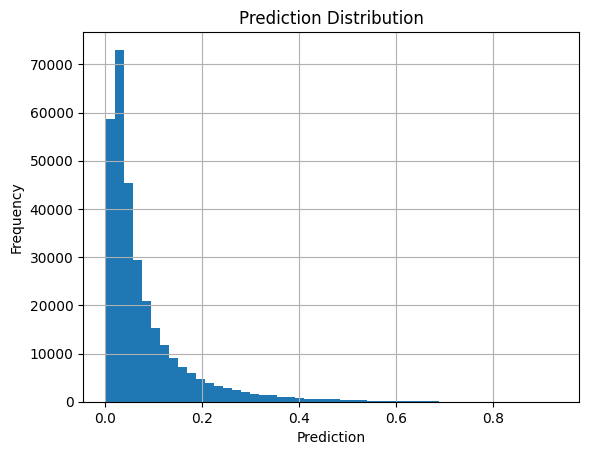

Evaluation on probability:
ROC AUC: 0.7829
Avg Precision: 0.2729
Log Loss: 0.2386


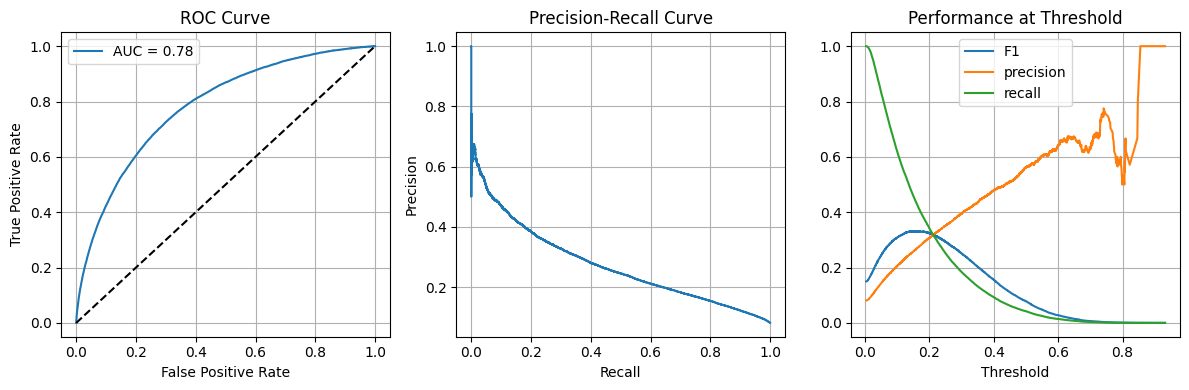

Evaluation at Max-F1 threshold=0.16:
Accuracy: 0.8617
Precision: 0.2718
Recall: 0.4243
F1 Score: 0.3313


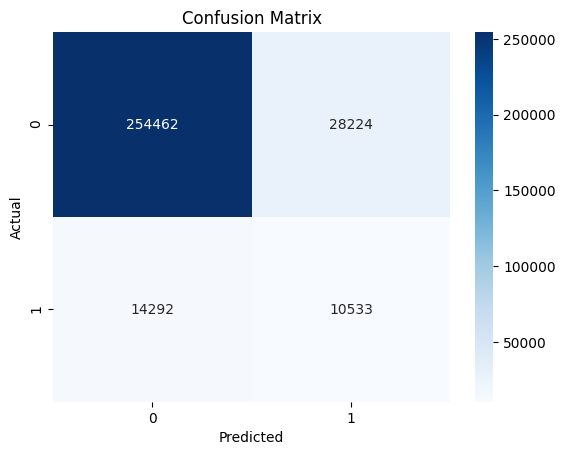


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.90      0.92    282686
           1       0.27      0.42      0.33     24825

    accuracy                           0.86    307511
   macro avg       0.61      0.66      0.63    307511
weighted avg       0.89      0.86      0.88    307511



In [36]:
metrics = evaluate_classification_model(y_true=y_train, y_prob=oof_preds)

## Part 5: Model Explaination

This section provides transparency into how the model makes its predictions, using SHAP (SHapley Additive exPlanations) to interpret feature contributions both globally and locally.

In [74]:
def cal_shap_by_category(shap_values, X, feature):
    df_shap = pd.DataFrame(shap_values.values[:,:,1], columns=X.columns)
    df_feature_shap = X_train[[feature]].copy()
    df_feature_shap['shap'] = df_shap[feature]
    return df_feature_shap.groupby(feature)['shap'].mean().sort_values()

### 5.1) Global Explanation

Top 5 most impactful features:
1. `EXT_SOURCE_MEAN`: Averaged external credit scores. A higher value strongly decreases default risk.
2. `EXT_SOURCE_SUM`: Sum of external credit scores. Helps distinguish applicants with multiple strong signals.
3. `PCT_ANNUITY_TO_CREDIT`: Ratio of annuity to credit amount. Lower ratios indicate affordability and reduce risk.
4. `ORGANIZATION_TYPE`: Type of employer, associated with income stability.
  - **High-risk:** Transport: type 3, Realtor
  - **Low-risk:** Industry: type 12, Trade: type 6, Bank
5. `CODE_GENDER`: Male applicants generally show higher default risk than female.

These insights were visualized using
- `shap.plots.bar`: Global importance ranking.
- `shap.plots.beeswarm`: Distribution of SHAP values per feature.
- `shap.plots.heatmap`: Sorted SHAP matrix to highlight overall influence per observation.

In [37]:
shap_values, features = get_shap_features(model, X_train)

# Top features: 80
EXT_SOURCE_MEAN                                    0.4568
EXT_SOURCE_SUM                                     0.0990
PCT_ANNUITY_TO_CREDIT                              0.0969
ORGANIZATION_TYPE                                  0.0966
CODE_GENDER                                        0.0956
AMT_ANNUITY                                        0.0751
CREDIT_TO_GOOD                                     0.0729
NAME_EDUCATION_TYPE                                0.0719
PREV_PAY_DAYS_DELAY_MAX_MAX_CASH_LOANS             0.0649
PCT_CREDIT_TO_GOOD                                 0.0623
PREV_STATUS_PCT_SK_ID_PREV_COUNT_REFUSED           0.0614
BR_AMT_CREDIT_SUM_SUM_CLOSED                       0.0602
PREV_PAY_DAYS_DELAY_MAX_MAX_CONSUMER_LOANS         0.0599
NAME_FAMILY_STATUS                                 0.0546
FLAG_OWN_CAR                                       0.0529
DAYS_BIRTH                                         0.0514
OCCUPATION_TYPE                                    0.

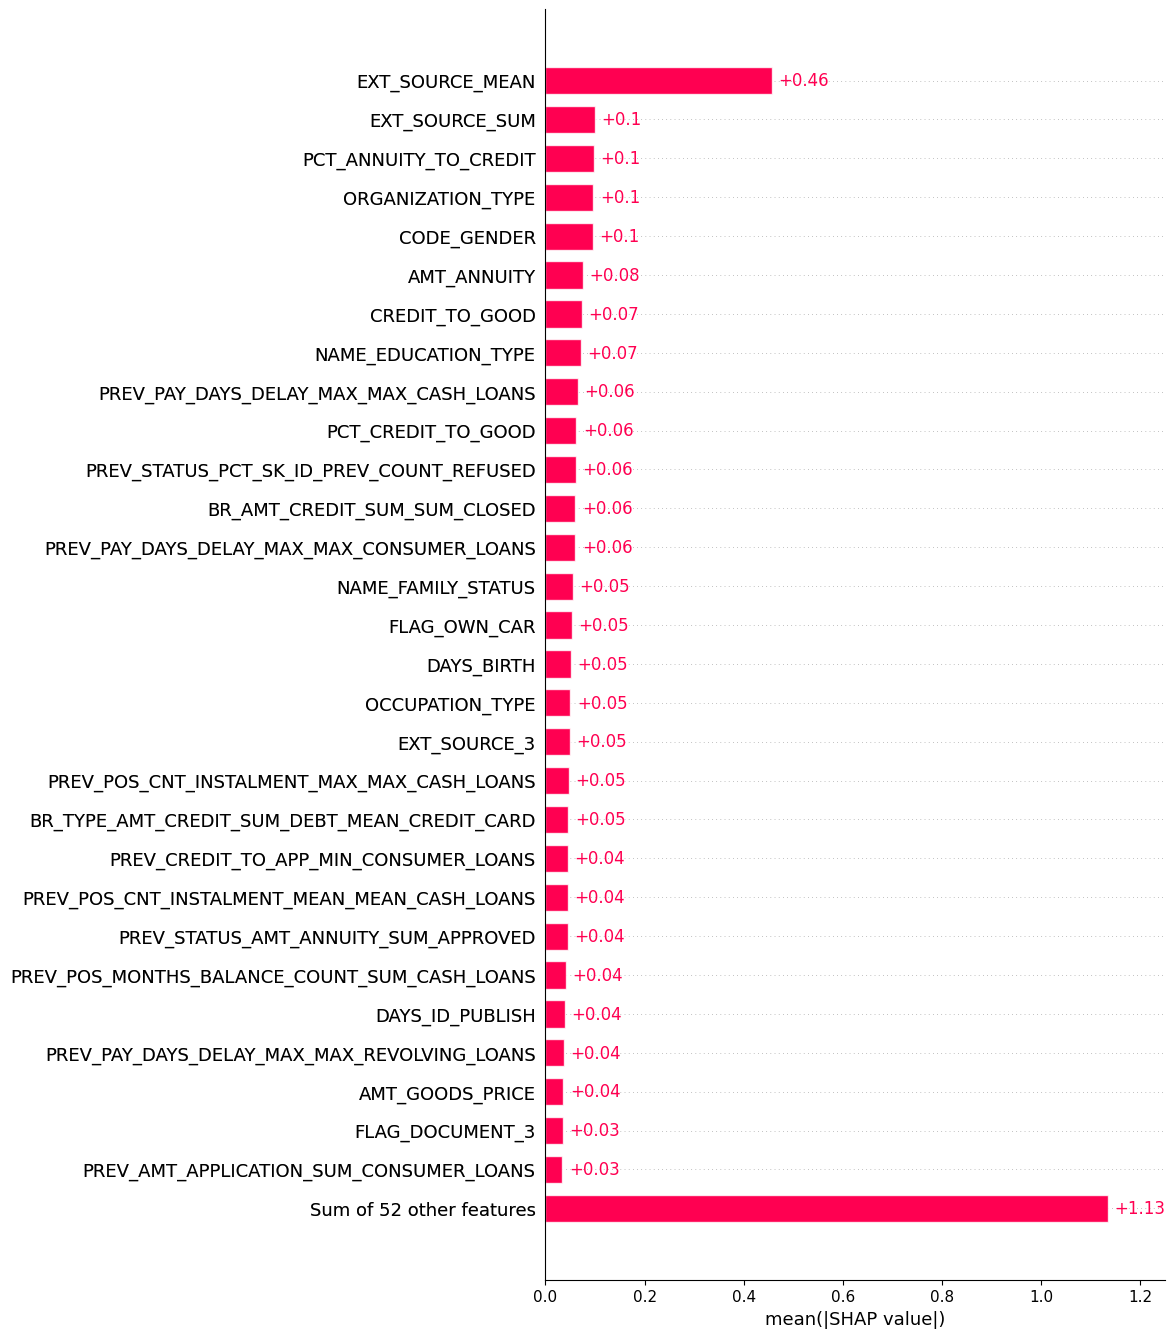

In [38]:
shap.plots.bar(shap_values[:, :, 1], max_display=30)

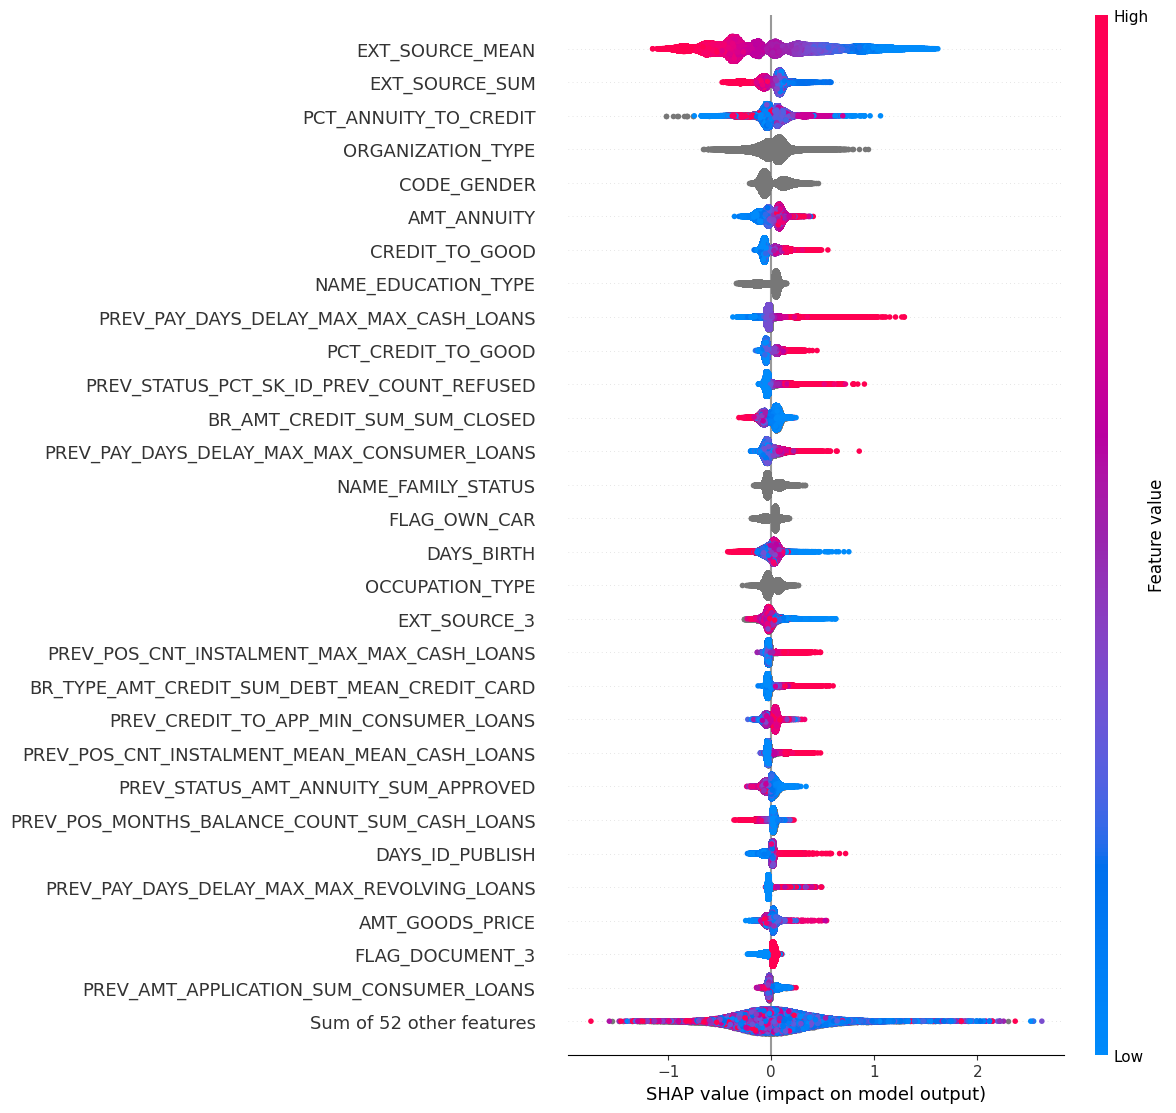

In [39]:
shap.plots.beeswarm(shap_values[:, :, 1], max_display=30)

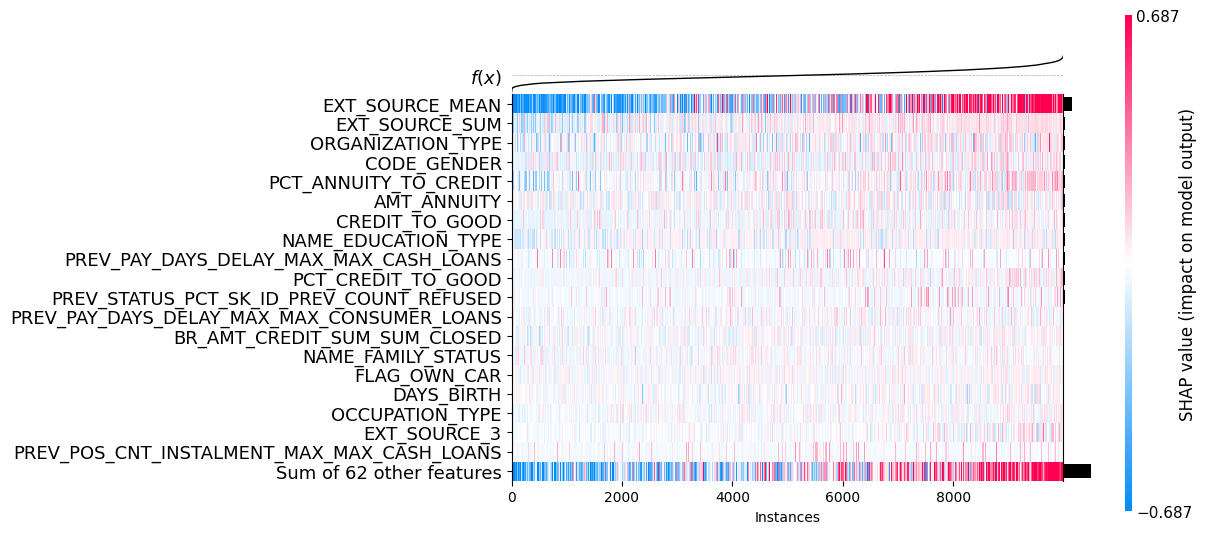

In [41]:
order = shap_values[:10000, :, 1].values.sum(axis=1).argsort()
shap.plots.heatmap(
    shap_values[:10000, :, 1],
    max_display=20,
    instance_order=order
)

In [76]:
cal_shap_by_category(shap_values, X_train, 'ORGANIZATION_TYPE')

ORGANIZATION_TYPE
Industry: type 12        -0.3662
Trade: type 6            -0.3430
Bank                     -0.3324
Security Ministries      -0.3314
Military                 -0.2948
Police                   -0.2644
Industry: type 9         -0.2631
Hotel                    -0.2173
Trade: type 4            -0.2068
School                   -0.1848
Kindergarten             -0.1523
Industry: type 13        -0.1483
Emergency                -0.1401
Industry: type 5         -0.1228
Medicine                 -0.1204
Transport: type 1        -0.1183
University               -0.1169
Trade: type 5            -0.1159
Industry: type 8         -0.1121
Industry: type 7         -0.1097
Government               -0.1096
Industry: type 2         -0.0986
Industry: type 6         -0.0891
Trade: type 1            -0.0865
Electricity              -0.0780
Industry: type 10        -0.0757
Religion                 -0.0656
Housing                  -0.0615
Services                 -0.0550
XNA                      

In [77]:
cal_shap_by_category(shap_values, X_train, 'CODE_GENDER')

CODE_GENDER
F     -0.0746
XNA   -0.0262
M      0.1362
Name: shap, dtype: float64

### 5.2) Local Explanation

To understand how the model arrives at individual predictions, we use SHAP waterfall plots to break down the impact of each feature for specific examples.

#### Example from class 0 (non-default)
This case was classified as low-risk due to strong positive credit signals and minimal delinquency history, despite a few minor warning flags. Supported by strong positive profile (negative SHAP value) from
- `EXT_SOURCE_MEAN` = 0.679 --> Strongly reduced the predicted risk (SHAP: −0.58)
- `PCT_ANNUITY_TO_CREDIT` = −0.895 --> Lower repayment burden, reduced risk (SHAP: −0.32)
- `PREV_PAY_DAYS_DELAY_MAX_MAX_CASH_LOANS` = -7 --> Indicates alway pay in advance for past loan payments, helpful in lowering risk

Despite a few risk-increasing factors:
- `PREV_STATUS_PCT_SK_ID_PREV_COUNT_REFUSED` = 0.4 --> Moderate indication of previous application refusals (SHAP: +0.13)

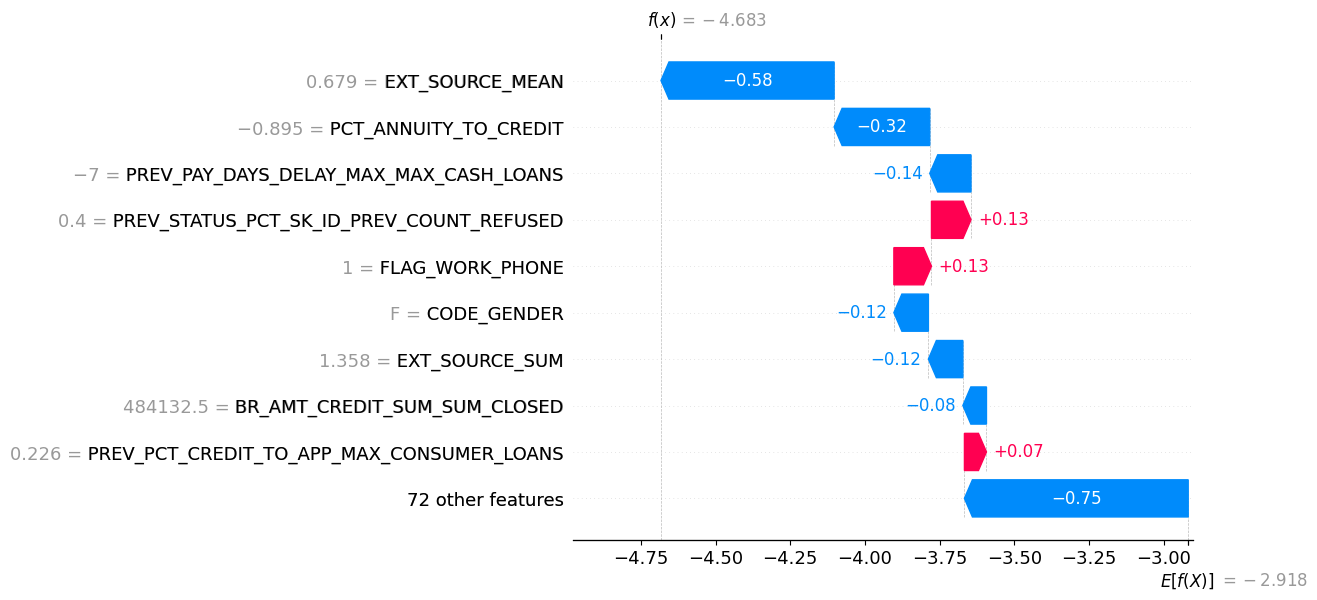

In [54]:
shap.plots.waterfall(shap_values[32, :, 1])

#### Example from class 1 (default)
This case is a clear high-risk profile, with all top contributing features strongly pushing the prediction toward default (positive SHAP values)
- `EXT_SOURCE_MEAN` = 0.001 --> Very low external score, indicating high risk (SHAP: +1.03)
- `PREV_PAY_DAYS_DELAY_MAX_MAX_CASH_LOANS` = 10,000 --> Indicates non-payment in past loans (SHAP: +0.92)
- `PREV_PAY_AMT_REMAIN_MEAN_MEAN_CASH_LOAN` = 1,325.32 --> High remaining amounts suggest poor repayment behavior (SHAP: +0.56)

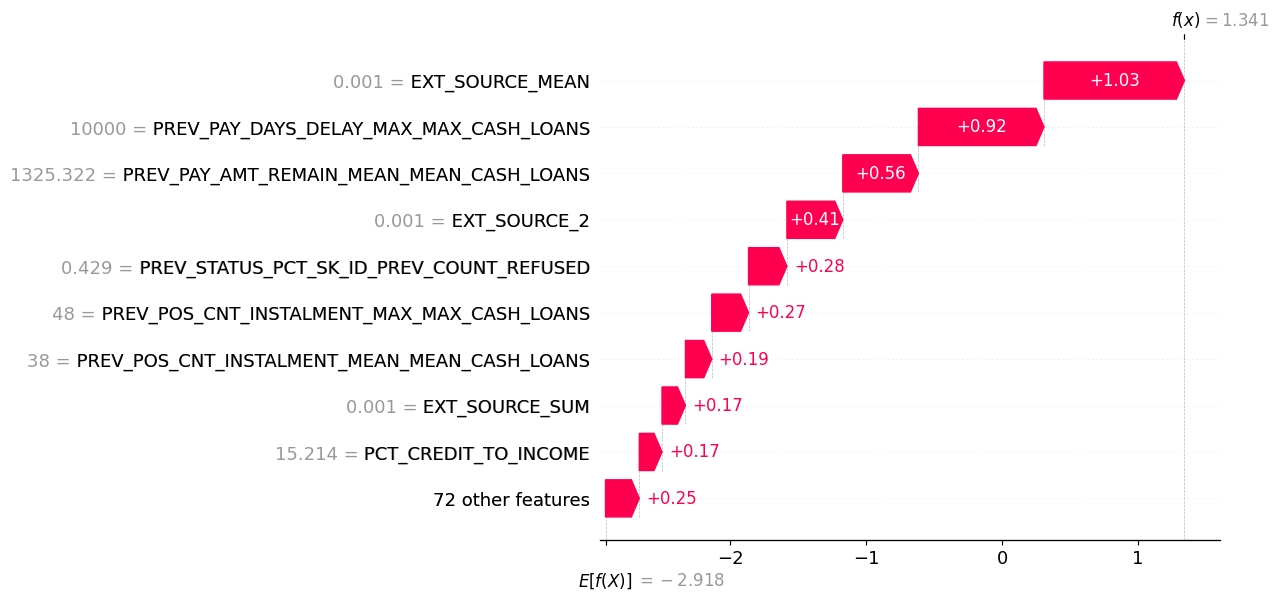

In [51]:
shap.plots.waterfall(shap_values[114668, :, 1])

## Part 6: Bussiness Impact Evaluation

### 6.1) Baseline Model

To establish a benchmark, we created a simple baseline model using only `EXT_SOURCE_MEAN` — the top SHAP-ranked feature. Scores were normalized to produce a ranking, simulating approval decisions.

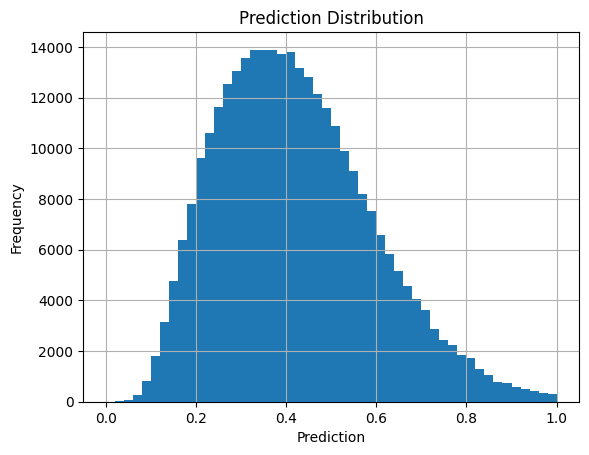

Evaluation on probability:
ROC AUC: 0.7165
Avg Precision: 0.1893
Log Loss: 0.5879


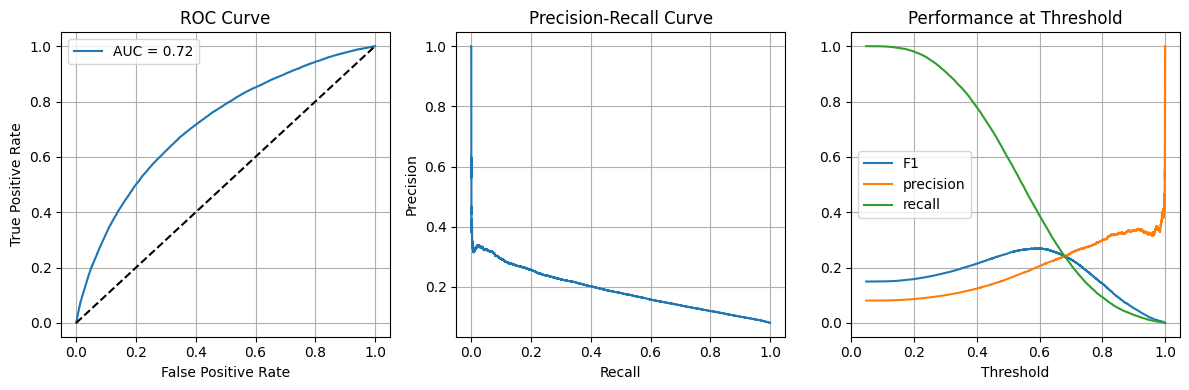

Evaluation at Max-F1 threshold=0.59:
Accuracy: 0.8222
Precision: 0.2014
Recall: 0.4054
F1 Score: 0.2691


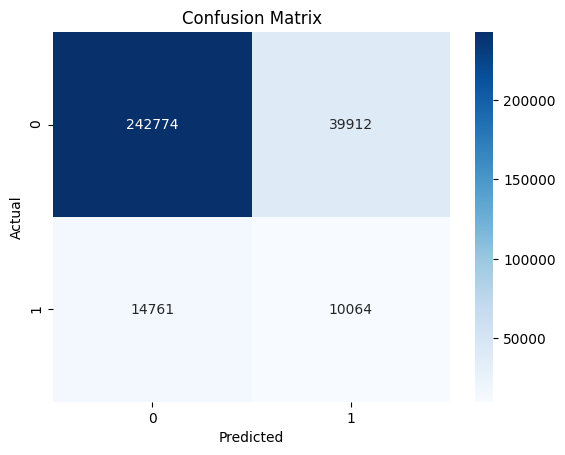


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.86      0.90    282686
           1       0.20      0.41      0.27     24825

    accuracy                           0.82    307511
   macro avg       0.57      0.63      0.58    307511
weighted avg       0.88      0.82      0.85    307511



In [78]:
y_base = (1 - X_train['EXT_SOURCE_MEAN'] / X_train['EXT_SOURCE_MEAN'].max()).fillna(0.5)
metrics = evaluate_classification_model(y_true=y_train, y_prob=y_base)

### 6.2) Business Metrics

We evaluated business outcomes based on approval strategies, using assumptions for financial outcomes, presented in millions.
- Profit (for non-default loans) = (1 - `TARGET`) × `AMT_CREDIT` × 6% (interest rate)
- Loss (for default loans) = `TARGET` × `AMT_CREDIT` × 50% (Loss Given Default)
- Net Profit = Profit − Loss

In [79]:
df_eval = df_app_train[['SK_ID_CURR', 'TARGET', 'AMT_CREDIT']].copy()
df_eval['model_prob'] = oof_preds
df_eval['baseline_prob'] = y_base
df_eval['model'] = (df_eval['model_prob'] >= 0.16).astype(int)
df_eval['model_0.05'] = (df_eval['model_prob'] >= 0.05).astype(int)
df_eval['model_0.10'] = (df_eval['model_prob'] >= 0.10).astype(int)
df_eval['model_0.25'] = (df_eval['model_prob'] >= 0.25).astype(int)
df_eval['baseline'] = (df_eval['baseline_prob'] >= 0.6).astype(int)
df_eval['approve_all'] = 0

In [80]:
df_eval['est_profit'] = (1 - df_eval['TARGET']) * df_eval['AMT_CREDIT'] * 0.06
df_eval['est_loss'] = df_eval['TARGET'] * df_eval['AMT_CREDIT'] * 0.5

target_cols = ['model', 'model_0.05', 'model_0.10', 'model_0.25', 'baseline', 'approve_all']
for col in target_cols:
    df_eval['profit_'+col] = (1 - df_eval[col]) * df_eval['est_profit']
    df_eval['loss_'+col] = (1 - df_eval[col]) * df_eval['est_loss']
    df_eval['net_profit_'+col] = df_eval['profit_'+col] - df_eval['loss_'+col]

In [82]:
df_eval_sum = pd.DataFrame(index=target_cols)
df_eval_sum['approval_rate'] = 1 - df_eval[target_cols].mean()
df_eval_sum['default_rate'] = (1 - df_eval[target_cols]).multiply(df_eval['TARGET'], axis=0).mean() \
                                / df_eval_sum['approval_rate']
df_eval_sum['profit'] = df_eval[['profit_'+c for c in target_cols]].sum().values / 1000000
df_eval_sum['loss'] = df_eval[['loss_'+c for c in target_cols]].sum().values / 1000000
df_eval_sum['net_profit'] = df_eval[['net_profit_'+c for c in target_cols]].sum().values / 1000000

We compared several strategies
- **Approved All**: Highest profit, but highest loss --> lowest net profit
- **Model (Max-F1)**: Good balance of approval vs default rate --> almost highest net profit
- **Baseline**: Higher default rate and lower approval rate --> higher loss and lower profit than model
- **Model @ 0.10**: Lower profit, much lower loss --> best net profit, depending on risk appetite
- **Model @ 0.05**: Very low risk, but too low profit based on only 52% approval
- **Model @ 0.25**: Higher approval but high loss reduced net proit

The trade-off between approval rate and default risk should align with business risk tolerance and credit policy. For example, while approving everyone yields the highest gross profit, it also leads to unacceptably high default losses. In contrast, the model's Max-F1 threshold offers an optimal risk-return balance under the given assumptions.

In [83]:
df_eval_sum

,approval_rate,default_rate,profit,loss,net_profit
model,0.8692,0.0526,9298.0407,4165.1673,5132.8734
model_0.05,0.5240,0.0251,5965.2338,1293.4459,4671.7879
model_0.10,0.7550,0.0404,8284.2822,2868.8543,5415.4279
model_0.25,0.9418,0.0641,9869.0262,5332.3884,4536.6378
baseline,0.8475,0.0584,9098.5329,4508.7838,4589.7491
approve_all,1.0000,0.0807,10221.6139,6923.4260,3298.1880


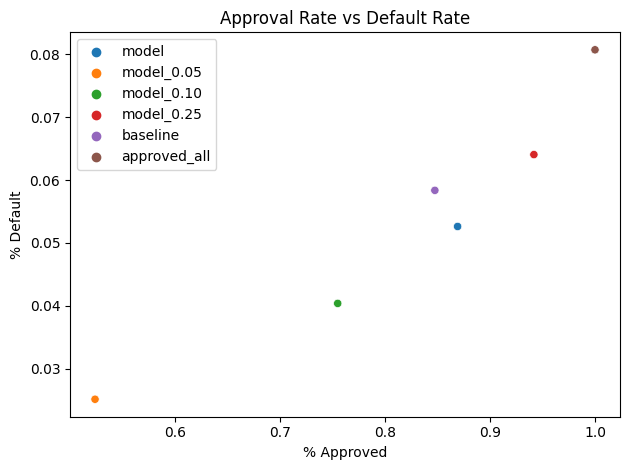

In [61]:
sns.scatterplot(
    data=df_eval_sum, x='pct_approved', y='pct_default', 
    hue=df_eval_sum.index
)
plt.title('Approval Rate vs Default Rate')
plt.xlabel('% Approved')
plt.ylabel('% Default')
plt.tight_layout()
plt.show()

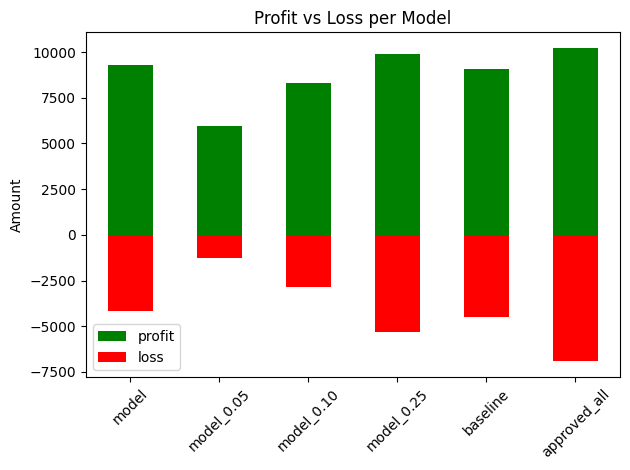

In [62]:
df_plot = df_eval_sum[['profit', 'loss']].copy()
df_plot['loss'] = -df_plot['loss']

df_plot.plot(kind='bar', stacked=True, color=['green', 'red'])
plt.title('Profit vs Loss per Model')
plt.ylabel('Amount')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Part 7: Post-Deployment Monitoring

Continuous performance monitoring is critical to ensure it remains accurate, fair, and aligned with business goals. This section outlines a monitoring framework across 3 key parts

1. **Prediction Consistency**: Tracking prediction score distribution drift by compared Out-sample (after deployment) to In-sample (training period)
2. **Data Drift Detection**: Track feature distributions over time compared to training data. Use statistical tests e.g. KS test.

Test Statistic measures the maximum distance between the two cumulative distributions. In general,
  - `0.01–0.03`: Small shift
  - `> 0.05`: Moderate shift
  - `> 0.1`: Large shift
3. **Performance Monitoring**: Compared to traditional model and monitoring overtime
  - Approval rate
  - Default rate (might be delay)
  - Net profit

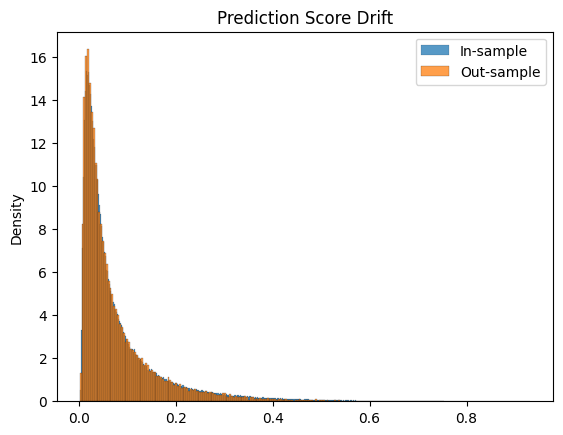

In [86]:
sns.histplot(oof_preds, label='In-sample', stat='density')
sns.histplot(test_preds, label='Out-sample', color='C1', stat='density')
plt.title("Prediction Score Drift")
plt.legend()
plt.show()

In [91]:
from scipy.stats import ks_2samp

drift_result = {}
for col in features[:10].index:
    stat, _ = ks_2samp(X_train[col].dropna(), X_test[col].dropna())
    drift_result[col] = {'ks_stat': stat}

df_drift = pd.DataFrame(drift_result).T.sort_values('ks_stat', ascending=False)

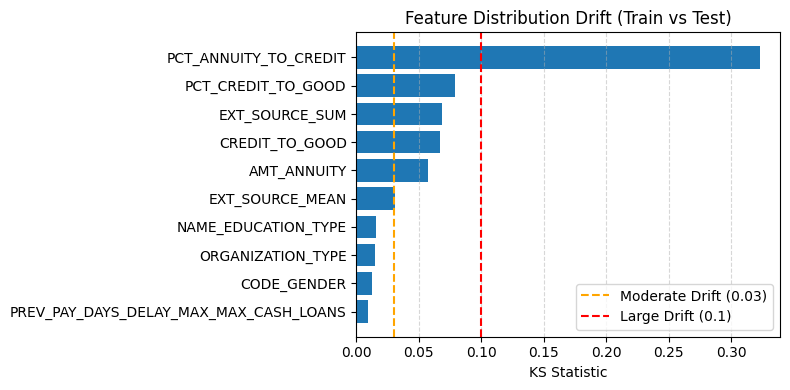

In [96]:
plt.figure(figsize=(8, 4))
plt.barh(df_drift.index, df_drift['ks_stat']) #, color='steelblue')
plt.axvline(x=0.03, color='orange', linestyle='--', label='Moderate Drift (0.03)')
plt.axvline(x=0.1, color='red', linestyle='--', label='Large Drift (0.1)')
plt.xlabel('KS Statistic')
plt.title('Feature Distribution Drift (Train vs Test)')
plt.gca().invert_yaxis()  # So highest drift at the top
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

In [101]:
print('Approval Rate Comparison')
print(f'- Traning: {(1 - oof_preds.mean()) * 100:.2f}%')
print(f'- Testing: {(1 - test_preds.mean()) * 100:.2f}%')

Approval Rate Comparison
- Traning: 92.02%
- Testing: 92.56%


## Part 8: Future Work & Improvement Ideas

This section highlights potential enhancements and exploratory directions that were not fully implemented due to time constraints
- Explore more feature interactions, guided by insights from SHAP value clustering.
- Perform model fine-tuning, including both hyperparameter optimization and experiment with alternative algorithms or model ensembles.
- Conduct segmented modeling beyound `NAME_CONTRACT_TYPE` (see Appendix 3). Alternative segmentation by user profile or behavior may yield better results.
- Identify user segments by loan purpose for targeted marketing strategies, aimed at acquiring low-risk users through personalized offers.